In [ ]:
ID = 386482020

In [1]:
# $ python3 -m venv venv
# $ . ./venv/bin/activate

In [2]:
#Better
!pip install requests BeautifulSoup4 fire

In [3]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import pandas as pd
import os, sys

import fire

In [4]:
#%%writefile ../pyscrap_url.py

def simple_get(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None.
    """
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content  #.encode(BeautifulSoup.original_encoding)
            else:
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None


def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)


def log_error(e):
    """
    It is always a good idea to log errors. 
    This function just prints them, but you can
    make it do anything.
    """
    print(e)
    
def get_elements(url, tag='',search={}, fname=None):
    """
    Downloads a page specified by the url parameter
    and returns a list of strings, one per tag element
    """
    
    if isinstance(url,str):
        response = simple_get(url)
    else:
        #if already it is a loaded html page
        response = url

    if response is not None:
        html = BeautifulSoup(response, 'html.parser')
        
        res = []
        if tag:    
            for li in html.select(tag):
                for name in li.text.split('\n'):
                    if len(name) > 0:
                        res.append(name.strip())
                       
                
        if search:
            soup = html            
            
            
            r = ''
            if 'find' in search.keys():
                print('findaing',search['find'])
                soup = soup.find(**search['find'])
                r = soup

                
            if 'find_all' in search.keys():
                print('findaing all of',search['find_all'])
                r = soup.find_all(**search['find_all'])
   
            if r:
                for x in list(r):
                    if len(x) > 0:
                        res.extend(x)
            
        return res

    # Raise an exception if we failed to get any data from the url
    raise Exception('Error retrieving contents at {}'.format(url))    
    
    
if get_ipython().__class__.__name__ == '__main__':
    fire(get_tag_elements)

In [87]:
res = get_elements('https://africafreak.com/100-most-influential-twitter-users-in-africa',tag='h2')

In [88]:
twitter_handle = [i.split('(')[-1].strip(')') for i in res]


In [89]:
url= 'https://www.atlanticcouncil.org/blogs/africasource/african-leaders-respond-to-coronavirus-on-twitter/#east-africa'
response = simple_get(url)

In [90]:
res_gov = get_elements(response, search={'find_all':{'class_':'twitter-tweet'}})
res_gov
strings=[]
for tag in res_gov:
    if tag.string !=None:
        strings.append(tag.string)

findaing all of {'class_': 'twitter-tweet'}


In [91]:
new_strings = [x for x in strings if len(x)<100]
gov_han = []
for i in range(0, len(new_strings),2):
    gov_han.append(new_strings[i])

In [92]:
gov_handle = [i.split('(')[-1] for i in gov_han]


In [139]:
import sys
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import re
import string

import matplotlib.dates as mdates
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)}) #A4 dimension


# to view all columns
pd.set_option("display.max.columns", None)

In [94]:
#Import the necessary methods from tweepy library  

#install tweepy if you don't have it
#!pip install tweepy
import tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

#sentiment analysis package
#!pip install textblob
from textblob import TextBlob

#general text pre-processor
#!pip install nltk
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')

#tweet pre-processor 
#!pip install tweet-preprocessor
import preprocessor as p

[nltk_data] Downloading package punkt to C:\Users\Moyinoluwa
[nltk_data]     Sobowale\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [95]:
from tweepy import OAuthHandler
from tweepy import API
from tweepy import Cursor
from datetime import datetime, date, time, timedelta
from collections import Counter
import sys

In [118]:
#Load Twitter API secrets to variables
consumer_key = "KJHR32AnACscIPig24x9w3L8u"
consumer_secret = "g101AbAwb1XVuOKgVUJW6aIzdgGptWozGDM20zs0Vi9wikezpM"
access_token = "769001288-q8N1d2mZ1L6QqzItHOiMCNK9ot0L5qR3jVmg85E9"
access_token_secret = "WKKD0DsLiqSwz8CZKYcFnZ7zwAw3OZNqeKX5wPpby4d2P"

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
auth_api = tweepy.API(auth)

In [100]:
#read the government officials and influencers account files
Govt = open("Govt_twi_han.csv", "r").readlines()
Influ = open("Influ_twi_han.csv", "r").readlines()

#store handles in a list
govt_officials = [i.rstrip("\n") for i in Govt]
influencers = [i.rstrip("\n") for i in Influ]

In [101]:
#screen_name, followers_count and friends_count for the government_officials
data = {}
data['screen_name'] = []
data['followers_count'] = []
data['friends_count'] = []
data['status'] = ["government_official" for i in govt_officials]
for target in govt_officials:
    try:
        u = auth_api.get_user(target)
        data['screen_name'].append(u.screen_name) 
        data['followers_count'].append(u.followers_count) 
        data['friends_count'].append(u.friends_count) 
    except Exception: # Accounts with issues are excluded
        pass

In [102]:
#screen_name, followers_count and friends_count for the influencers

for target in influencers:
    try:
        u = auth_api.get_user(target)
        data['screen_name'].append(u.screen_name)
        data['followers_count'].append(u.followers_count)
        data['friends_count'].append(u.friends_count)
    except Exception: # Accounts with issues are excluded
        pass
    
for target in data["screen_name"][36:]:
    data['status'].append("influencer")

In [104]:
data['favorite_count'] = []
data['retweet_count'] = []
for screen_name in data['screen_name']:
    favorite_counts = []
    retweet_counts = []
    
    for page in tweepy.Cursor(auth_api.user_timeline, screen_name=screen_name,count=100,include_rts=False,tweet_mode='extended').pages(5):
        favorite_count = sum([tweet.favorite_count for tweet in page])
        favorite_counts.append(favorite_count) 
        retweet_count = sum([tweet.retweet_count for tweet in page]) 
        retweet_counts.append(retweet_count) 
    
    # append total sum(favorite_counts) and total sum(retweet_counts) of an account different lists
    data['favorite_count'].append(sum(favorite_counts)) # append total sum(favorite_count) of an account to list
    data['retweet_count'].append(sum(retweet_counts))

In [105]:

df = pd.DataFrame(data)

df["popularity_score"] = df["retweet_count"] + df["favorite_count"]
df["reach_score"] = df["followers_count"] - df["friends_count"]

df.to_csv(r'C:\Users\Moyinoluwa Sobowale\Downloads\twitter_dataset.csv',index=False)

In [119]:
df = pd.read_csv("twitter_dataset.csv")
df

,screen_name,followers_count,friends_count,status,favorite_count,retweet_count,popularity_score,reach_score
0,EswatiniGovern1,11341,82,government_official,12292,3119,15411,11259
1,MalawiGovt,39399,26,government_official,14668,5441,20109,39373
2,hagegeingob,192661,55,government_official,133807,22904,156711,192606
3,FinanceSC,127,224,government_official,123,18,141,-97
4,PresidencyZA,1600669,14,government_official,49946,18600,68546,1600655
...,...,...,...,...,...,...,...,...
124,Julius_S_Malema,3131984,651,influencer,182976,38183,221159,3131333
125,News24,3580020,632,influencer,37207,12227,49434,3579388
126,SAPresident,18,14,influencer,0,0,0,4
127,GarethCliff,1974727,356,influencer,27663,5467,33130,1974371


In [120]:
# rank government_officials by popularity_score
govt_popularity = df.sort_values("popularity_score",ascending=False)[df["status"] == "government_official"].head(10)
govt_popularity

C:\Users\Moyinoluwa Sobowale\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,screen_name,followers_count,friends_count,status,favorite_count,retweet_count,popularity_score,reach_score
26,NAkufoAddo,1510438,352,government_official,1412304,232751,1645055,1510086
32,MBuhari,3274947,26,government_official,955975,270392,1226367,3274921
13,SudanPMHamdok,371799,115,government_official,857025,168212,1025237,371684
15,KagutaMuseveni,1816280,28,government_official,758969,139434,898403,1816252
10,PaulKagame,1987246,181,government_official,649008,208156,857164,1987065
6,edmnangagwa,547256,116,government_official,526297,117878,644175,547140
33,Macky_Sall,1377059,171,government_official,422911,67728,490639,1376888
11,M_Farmaajo,424944,2,government_official,298384,62023,360407,424942
19,Presidence_RDC,341714,125,government_official,222305,30823,253128,341589
24,AOuattara_PRCI,834266,23,government_official,189788,33451,223239,834243


In [121]:
# rank influencers by popularity_score
influ_popularity = df.sort_values("popularity_score",ascending=False)[df["status"] == "influencer"].head(10)
influ_popularity

C:\Users\Moyinoluwa Sobowale\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,screen_name,followers_count,friends_count,status,favorite_count,retweet_count,popularity_score,reach_score
128,Trevornoah,10811250,325,influencer,2645058,438592,3083650,10810925
91,MbuyiseniNdlozi,1080817,5474,influencer,242178,40432,282610,1075343
124,Julius_S_Malema,3131984,651,influencer,182976,38183,221159,3131333
115,euphonik,1756311,65,influencer,116952,14374,131326,1756246
116,UlrichJvV,1042449,530241,influencer,85319,10256,95575,512208
123,helenzille,1443531,2302,influencer,50974,11397,62371,1441229
117,OfficialCSA,1160280,1996,influencer,45640,6163,51803,1158284
125,News24,3580020,632,influencer,37207,12227,49434,3579388
63,audisouthafrica,215459,1155,influencer,39154,4576,43730,214304
118,MTVBaseAfrica,1416530,109,influencer,32209,5449,37658,1416421


In [122]:
# rank government_official by reach_score
govt_reach_score = df.sort_values("reach_score",ascending=False)[df["status"] == "government_official"].head(10)
govt_reach_score

C:\Users\Moyinoluwa Sobowale\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,screen_name,followers_count,friends_count,status,favorite_count,retweet_count,popularity_score,reach_score
32,MBuhari,3274947,26,government_official,955975,270392,1226367,3274921
10,PaulKagame,1987246,181,government_official,649008,208156,857164,1987065
15,KagutaMuseveni,1816280,28,government_official,758969,139434,898403,1816252
4,PresidencyZA,1600669,14,government_official,49946,18600,68546,1600655
26,NAkufoAddo,1510438,352,government_official,1412304,232751,1645055,1510086
33,Macky_Sall,1377059,171,government_official,422911,67728,490639,1376888
9,StateHouseKenya,1105030,214,government_official,175158,41679,216837,1104816
24,AOuattara_PRCI,834266,23,government_official,189788,33451,223239,834243
6,edmnangagwa,547256,116,government_official,526297,117878,644175,547140
11,M_Farmaajo,424944,2,government_official,298384,62023,360407,424942


In [123]:

# rank influencers by reach_score
influ_reach_score = df.sort_values("reach_score",ascending=False)[df["status"] == "influencer"].head(10)
influ_reach_score

C:\Users\Moyinoluwa Sobowale\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,screen_name,followers_count,friends_count,status,favorite_count,retweet_count,popularity_score,reach_score
128,Trevornoah,10811250,325,influencer,2645058,438592,3083650,10810925
125,News24,3580020,632,influencer,37207,12227,49434,3579388
124,Julius_S_Malema,3131984,651,influencer,182976,38183,221159,3131333
127,GarethCliff,1974727,356,influencer,27663,5467,33130,1974371
115,euphonik,1756311,65,influencer,116952,14374,131326,1756246
123,helenzille,1443531,2302,influencer,50974,11397,62371,1441229
118,MTVBaseAfrica,1416530,109,influencer,32209,5449,37658,1416421
121,5FM,1164521,411,influencer,12882,1937,14819,1164110
117,OfficialCSA,1160280,1996,influencer,45640,6163,51803,1158284
120,loyisogola,1085380,3950,influencer,20124,2932,23056,1081430


In [124]:
#select top 10 government officials using govt_popularity and govt_reach_score
from collections import Counter
govt_pop_reach = govt_popularity + govt_reach_score # concatenate the lists
count_govt = Counter(govt_pop_reach) # check those that appear in both lists
top10_govt = []
for govt in count_govt:
    if not govt in ["Presidence_RDC", "StateHouseKenya"]: 
        top10_govt.append(govt) #distinguish those with higher popularity and reach_score 

In [125]:
#select top 10 influencers using influ_popularity and influ_reach_score
from collections import Counter
influ_pop_reach = influ_popularity + influ_reach_score # concatenate the lists
count_influ = Counter(influ_pop_reach) # check those that appear in both lists
top10_influencers = []
for influ in count_influ:
    if not influ in ["loyisogola", "5FM", "audisouthafrica"]: 
        top10_influencers.append(influ) #distinguish those with higher popularity and reach score


In [126]:
hashtags_count = {}
hashtags = {}

In [130]:
#extract screen_names as keys in dict(hashtags) and their respective hashtags with their count as values
for screen_name in data['screen_name']:
    hashtags[screen_name]={}
    for status in Cursor(auth_api.user_timeline, screen_name=screen_name).items(200):
    #    tweet_count+= 1
        if hasattr(status, "entities"):
            entities = status.entities 
        # get hashtags
        if "hashtags" in entities:
        
            for ent in entities["hashtags"]:
                if ent is not None:
                    if "text" in ent:
                        hashtag = ent["text"]
                        if hashtag is not None:
                            if hashtag in hashtags[screen_name].keys():
                                hashtags[screen_name][hashtag]+=1
                                hashtags_count[hashtag]+=1
                            else:
                                hashtags[screen_name][hashtag] = 1
                                hashtags_count[hashtag] = 1

In [131]:
print(entities)


{'hashtags': [{'text': 'MatchInAfrica', 'indices': [53, 67]}], 'symbols': [], 'user_mentions': [{'screen_name': 'rogerfederer', 'name': 'Roger Federer', 'id': 1337785291, 'id_str': '1337785291', 'indices': [15, 28]}, {'screen_name': 'RafaelNadal', 'name': 'Rafa Nadal', 'id': 344634424, 'id_str': '344634424', 'indices': [29, 41]}, {'screen_name': 'BillGates', 'name': 'Bill Gates', 'id': 50393960, 'id_str': '50393960', 'indices': [42, 52]}], 'urls': [{'url': 'https://t.co/8je1vCTt6j', 'expanded_url': 'https://twitter.com/rogerfederer/status/1225418063908044800', 'display_url': 'twitter.com/rogerfederer/s…', 'indices': [68, 91]}]}


In [132]:
#change values of keys in dict(hashtags) to lowercase
def _lowercase(obj):
    if isinstance(obj, dict):
        return {k.lower(): v for k,v in obj.items()}
hashtags_lower = {k: _lowercase(v) for k,v in hashtags.items()}

In [133]:
#get new count for all unique hashtags
hasht_count = {}
for screen_name in hashtags_lower:
    for hasht in hashtags_lower[screen_name]:
        if not hasht in hasht_count.keys():
            hasht_count[hasht] = hashtags_lower[screen_name][hasht] # append the unique hashtag count with it's user count
        else:
            hasht_count[hasht] += hashtags_lower[screen_name][hasht] # increase the unique hashtag count with it's user count

In [134]:
#top 5 unique hashtags
top_5 = sorted(hasht_count, key=hasht_count.get, reverse=True)[:5]
top_5

['covid19', 'africa', 'cnbcafrica', 'coronavirus', 'ethiopia']

In [135]:
#hashtags with very low engagements
bottom_5 = sorted(hasht_count, key=hasht_count.get, reverse=False)[:5]
bottom_5

['eswatini',
 'malawiinauguration2020',
 '56thindependence',
 'presidentspecialaddress',
 'presidentialsweatingin']

In [136]:

# group influencers and government officials top_5_unique_hashtags count in a dict
hash_df = {}
hash_df["hashtags"] = [hashtag for hashtag in top_5]
hash_df["government_officials"] = []
hash_df["influencers"] = []
count = len(hashtags_lower)

for hashtag in top_5:
    govt_count = []
    infl_count = []
    for screen_name in data['screen_name']:
        if hashtag in hashtags_lower[screen_name]:
            if count>93: # govt_officials are the first 36 screen_names
                    govt_count.append(hashtags_lower[screen_name][hashtag])
            else:
                infl_count.append(hashtags_lower[screen_name][hashtag])
            count-=1
    hash_df["government_officials"].append(sum(govt_count))
    hash_df["influencers"].append(sum(infl_count))

In [138]:
hashtag_df = pd.DataFrame(hash_df)
hashtag_df

,hashtags,government_officials,influencers
0,covid19,276,290
1,africa,0,117
2,cnbcafrica,0,113
3,coronavirus,0,90
4,ethiopia,0,69


([<matplotlib.axis.XTick at 0x1866df78e88>,
 <a list of 5 Text xticklabel objects>)

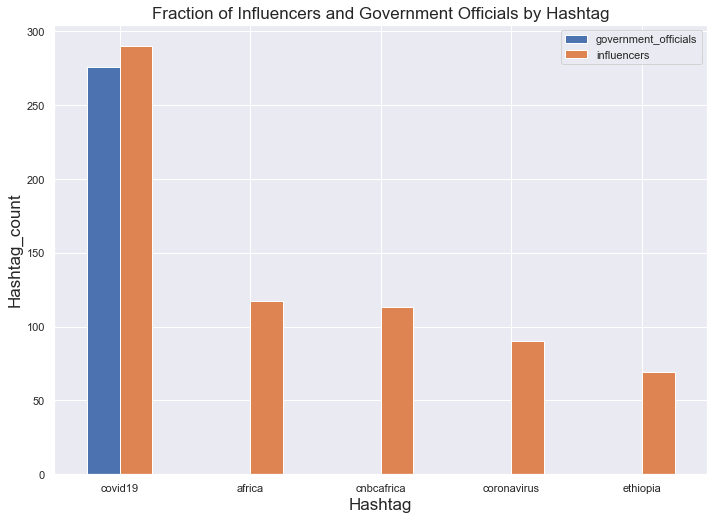

In [145]:

fig, ax = plt.subplots()
hashtag_df.plot(ax=ax,kind="bar", rot=0)
ax.set_title("Fraction of Influencers and Government Officials by Hashtag", fontsize=17)
ax.set_xlabel("Hashtag", fontsize=17)
ax.set_ylabel("Hashtag_count", fontsize=17)
plt.xticks((0,1,2,3,4),(hashtag_df["hashtags"]))